In [1]:
import numpy as np
import matplotlib.pyplot as plt

import stim
from beliefmatching import BeliefMatching
import pymatching
import scipy.optimize as opt
import itertools

import networkx as nx

from tqdm import tqdm

In [2]:
import ldpc_codes_funcs as ldpc_fun

In [3]:
W_A = 2
W_B = 2

l=2
m=3
A_terms, B_terms = ([('x', 1), ('y', 2)], [('x', 2), ('z', 4)])
code_2_3 = ldpc_fun.TB_LDPC_code(l,m)
H_X, H_Z = code_2_3.generate_stabilizers(W_A, W_B, A_terms, B_terms)
X_ops, Z_ops = code_2_3.generate_css_logical_ops_symplectic()
d = code_2_3.distance_from_logicals()
print(code_2_3.n, code_2_3.k, code_2_3.d)


12 2 3


In [4]:
l=4
m=7
code_4_5 = ldpc_fun.TB_LDPC_code(l,m)
# A_terms, B_terms = code_4_5.find_random_tb_code(W_A,W_B,k_min=4,d_min=5)
A_terms, B_terms = ([('y', 6), ('z', 22)], [('y', 1), ('y', 2)])
H_X, H_Z = code_4_5.generate_stabilizers(W_A, W_B, A_terms, B_terms)
X_ops, Z_ops = code_4_5.generate_css_logical_ops_symplectic()
d = code_4_5.distance_from_logicals()
print(code_4_5.n, code_4_5.k, code_4_5.d)

56 4 5


In [5]:
l = 4
m = 3
code_4_3 = ldpc_fun.TB_LDPC_code(l,m)
A_terms, B_terms = ([('x', 1), ('z', 7)], [('y', 2), ('x', 0)])
H_X, H_Z = code_4_3.generate_stabilizers(W_A, W_B, A_terms, B_terms)
X_ops, Z_ops = code_4_3.generate_css_logical_ops_symplectic()
d = code_4_3.distance_from_logicals()
print(code_4_3.n, code_4_3.k, code_4_3.d)

24 4 3


In [6]:
l = 4
m = 11
code_4_7 = ldpc_fun.TB_LDPC_code(l,m)
# A_terms, B_terms = code_4_9.find_random_tb_code(W_A,W_B,k_min=4,d_min=9)
A_terms, B_terms = ([('z', 42), ('x', 0)], [('x', 1), ('z', 1)])
H_X, H_Z = code_4_7.generate_stabilizers(W_A, W_B,A_terms, B_terms)
X_ops, Z_ops = code_4_7.generate_css_logical_ops_symplectic()
d = code_4_7.distance_from_logicals()
print(code_4_7.n, code_4_7.k, code_4_7.d)

88 4 7


In [7]:
codes = [code_2_3, code_4_3, code_4_5, code_4_7]

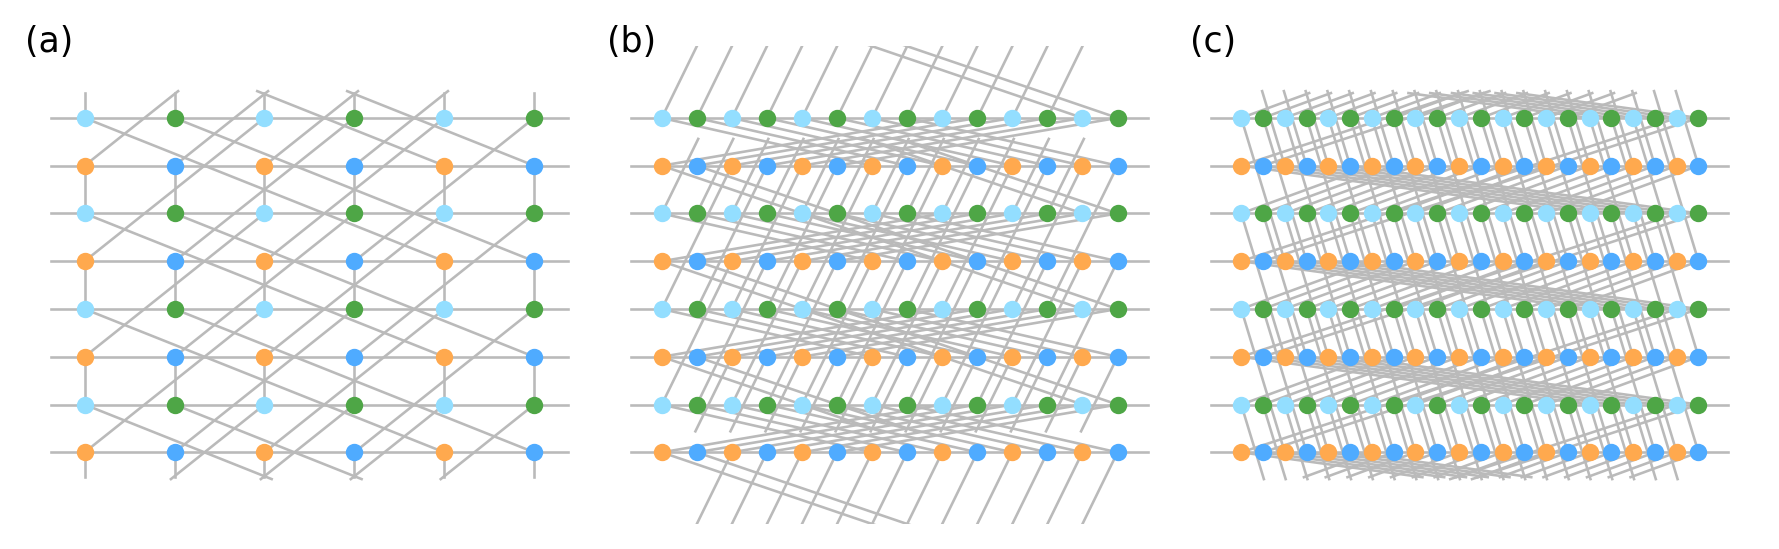

In [8]:
fig, axes = plt.subplots(ncols=3, nrows=1, dpi=250)


fig.set_size_inches(7.05826, 2.1)

fig.subplots_adjust(bottom = 0.04, top=0.95, left=0.01, right=0.99, wspace=0.02, hspace=0.4)

for code, ax in zip([code_4_3, code_4_5, code_4_7],np.reshape(axes,(3,))):   
    G, pos = ldpc_fun.generate_tanner_graph(code)
    
    # Group coordinates by type
    coords_by_type = {}
    for (t, idx), (x, y) in pos.items():
        if t=='d' and idx<code.n//2:
            ty = 'd1'
        elif t=='d':
            ty = 'd2'
        else:
            ty = t
        coords_by_type.setdefault(ty, []).append((x, y))
    
    # Choose a color for each type
    colors = {'d1': '#93DEFF', 'd2': '#4FABFF', 'X': '#FFA94E', 'Z': '#4EA646'}

    lw = 0.75
    
    # Create the plot
    for t, pts in coords_by_type.items():
        xs, ys = zip(*pts)
        ax.scatter(xs, ys, color=colors[t], label=t, s=16, zorder=1)  
    
    for x, row in enumerate(code.H_X):
        connections = [i for i, val in enumerate(row) if val == 1]
        x0, y0 = pos[('X',x)]
        for c in connections:
            x1, y1 = pos[('d',c)]
            dist_x = np.abs(x1-x0)
            dist_y = np.abs(y1-y0)
            if dist_y>(code.l*2-code.l):
                real_height = 1 + (2*code.l - max(y1,y0)) + (min(y0,y1) - 1)
                if dist_x==0:
                    slope = 0
                    step = 0
                    ax.plot([x0,x0+np.sign(x1-x0)*step],[y0, y0-0.26*code.l/2], c='#BABABA', zorder=0, linewidth=lw)
                    ax.plot([x1,x1-np.sign(x1-x0)*step],[y1, y1+0.26*code.l/2], c='#BABABA', zorder=0, linewidth=lw)
                else:
                    slope = np.sign(y0-code.l)*real_height/dist_x
                    step = 0.26*code.l/2/np.abs(slope)*real_height
                    ax.plot([x0,x0+np.sign(x1-x0)*step],[y0, y0+slope*step], c='#BABABA', zorder=0, linewidth=lw)
                    ax.plot([x1,x1-np.sign(x1-x0)*step],[y1, y1-slope*step], c='#BABABA', zorder=0, linewidth=lw)
            elif dist_x>(code.m*2-2):
                ax.plot([x0,x0-np.sign(x1-x0)*0.25*code.m/2],[y0,y0], c='#BABABA', zorder=0, linewidth=lw)
                ax.plot([x1,x1+np.sign(x1-x0)*0.25*code.m/2],[y1,y1], c='#BABABA', zorder=0, linewidth=lw)
            else:
                ax.plot([x0,x1],[y0,y1], c='#BABABA', zorder=0, linewidth=lw)
    
    for z, row in enumerate(code.H_Z):
        connections = [i for i, val in enumerate(row) if val == 1]
        x0, y0 = pos[('Z',z)]
        for c in connections:
            x1, y1 = pos[('d',c)]
            dist_x = np.abs(x1-x0)
            dist_y = np.abs(y1-y0)
            if dist_y>(code.l*2-code.l):
                real_height = 1 + (2*code.l - max(y1,y0)) + (min(y0,y1) - 1)
                if dist_x==0:
                    slope = 0
                    step = 0
                    ax.plot([x0,x0+np.sign(x1-x0)*step],[y0, y0+0.26*code.l/2], c='#BABABA', zorder=0, linewidth=lw)
                    ax.plot([x1,x1-np.sign(x1-x0)*step],[y1, y1-0.26*code.l/2], c='#BABABA', zorder=0, linewidth=lw)
                else:
                    slope = np.sign(y0-code.l)*real_height/dist_x
                    step = 0.26*code.l/2/np.abs(slope)*real_height
                    ax.plot([x0,x0+np.sign(x1-x0)*step],[y0, y0+slope*step], c='#BABABA', zorder=0, linewidth=lw)
                    ax.plot([x1,x1-np.sign(x1-x0)*step],[y1, y1-slope*step], c='#BABABA', zorder=0, linewidth=lw)
            elif dist_x>(code.m*2-2):
                ax.plot([x0,x0-np.sign(x1-x0)*0.25*code.m/2],[y0,y0], c='#BABABA', zorder=0, linewidth=lw)
                ax.plot([x1,x1+np.sign(x1-x0)*0.25*code.m/2],[y1,y1], c='#BABABA', zorder=0, linewidth=lw)
            else:
                ax.plot([x0,x1],[y0,y1], c='#BABABA', zorder=0, linewidth=lw)
    
    # Remove axes
    ax.axis('off')
    ax.set_ylim(-0.5,9.5)
    # keep aspect ratio square
    # ax.set_aspect('equal')

fig.text(0.01,0.94,'(a)')
fig.text(0.34,0.94,'(b)')
fig.text(0.67,0.94,'(c)')
plt.savefig('codes.pdf')

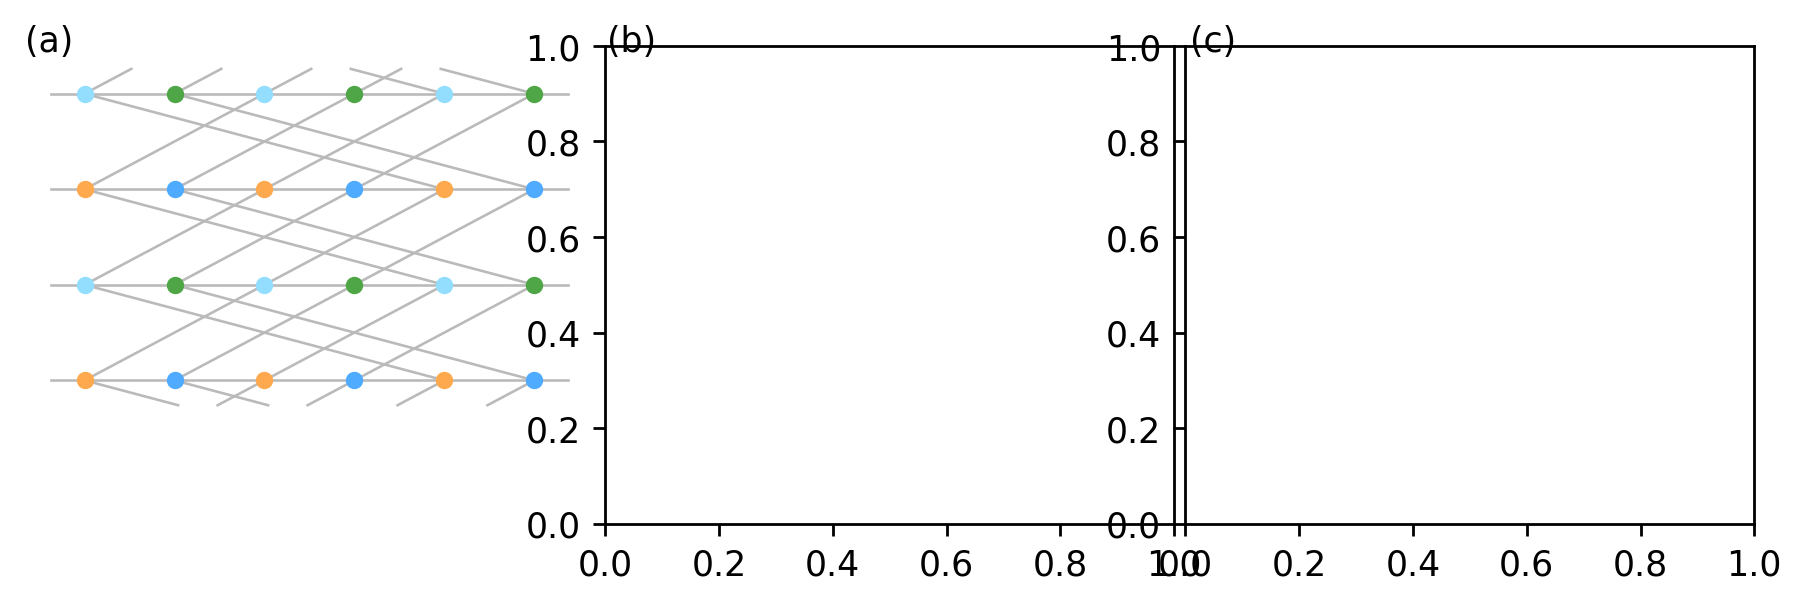

In [9]:
fig, axes = plt.subplots(ncols=3, nrows=1, dpi=250)


fig.set_size_inches(7.05826, 2.1)

fig.subplots_adjust(bottom = 0.04, top=0.95, left=0.01, right=0.99, wspace=0.02, hspace=0.4)

for code, ax in zip([code_2_3 ],np.reshape(axes,(3,))):   
    G, pos = ldpc_fun.generate_tanner_graph(code)
    
    # Group coordinates by type
    coords_by_type = {}
    for (t, idx), (x, y) in pos.items():
        if t=='d' and idx<code.n//2:
            ty = 'd1'
        elif t=='d':
            ty = 'd2'
        else:
            ty = t
        coords_by_type.setdefault(ty, []).append((x, y))
    
    # Choose a color for each type
    colors = {'d1': '#93DEFF', 'd2': '#4FABFF', 'X': '#FFA94E', 'Z': '#4EA646'}

    lw = 0.75
    
    # Create the plot
    for t, pts in coords_by_type.items():
        xs, ys = zip(*pts)
        ax.scatter(xs, ys, color=colors[t], label=t, s=16, zorder=1)  
    
    for x, row in enumerate(code.H_X):
        connections = [i for i, val in enumerate(row) if val == 1]
        x0, y0 = pos[('X',x)]
        for c in connections:
            x1, y1 = pos[('d',c)]
            dist_x = np.abs(x1-x0)
            dist_y = np.abs(y1-y0)
            if dist_y>(code.l*2-code.l):
                real_height = 1 + (2*code.l - max(y1,y0)) + (min(y0,y1) - 1)
                if dist_x==0:
                    slope = 0
                    step = 0
                    ax.plot([x0,x0+np.sign(x1-x0)*step],[y0, y0-0.26*code.l/2], c='#BABABA', zorder=0, linewidth=lw)
                    ax.plot([x1,x1-np.sign(x1-x0)*step],[y1, y1+0.26*code.l/2], c='#BABABA', zorder=0, linewidth=lw)
                else:
                    slope = np.sign(y0-code.l)*real_height/dist_x
                    step = 0.26*code.l/2/np.abs(slope)*real_height
                    ax.plot([x0,x0+np.sign(x1-x0)*step],[y0, y0+slope*step], c='#BABABA', zorder=0, linewidth=lw)
                    ax.plot([x1,x1-np.sign(x1-x0)*step],[y1, y1-slope*step], c='#BABABA', zorder=0, linewidth=lw)
            elif dist_x>(code.m*2-2):
                ax.plot([x0,x0-np.sign(x1-x0)*0.25*code.m/2],[y0,y0], c='#BABABA', zorder=0, linewidth=lw)
                ax.plot([x1,x1+np.sign(x1-x0)*0.25*code.m/2],[y1,y1], c='#BABABA', zorder=0, linewidth=lw)
            else:
                ax.plot([x0,x1],[y0,y1], c='#BABABA', zorder=0, linewidth=lw)
    
    for z, row in enumerate(code.H_Z):
        connections = [i for i, val in enumerate(row) if val == 1]
        x0, y0 = pos[('Z',z)]
        for c in connections:
            x1, y1 = pos[('d',c)]
            dist_x = np.abs(x1-x0)
            dist_y = np.abs(y1-y0)
            if dist_y>(code.l*2-code.l):
                real_height = 1 + (2*code.l - max(y1,y0)) + (min(y0,y1) - 1)
                if dist_x==0:
                    slope = 0
                    step = 0
                    ax.plot([x0,x0+np.sign(x1-x0)*step],[y0, y0+0.26*code.l/2], c='#BABABA', zorder=0, linewidth=lw)
                    ax.plot([x1,x1-np.sign(x1-x0)*step],[y1, y1-0.26*code.l/2], c='#BABABA', zorder=0, linewidth=lw)
                else:
                    slope = np.sign(y0-code.l)*real_height/dist_x
                    step = 0.26*code.l/2/np.abs(slope)*real_height
                    ax.plot([x0,x0+np.sign(x1-x0)*step],[y0, y0+slope*step], c='#BABABA', zorder=0, linewidth=lw)
                    ax.plot([x1,x1-np.sign(x1-x0)*step],[y1, y1-slope*step], c='#BABABA', zorder=0, linewidth=lw)
            elif dist_x>(code.m*2-2):
                ax.plot([x0,x0-np.sign(x1-x0)*0.25*code.m/2],[y0,y0], c='#BABABA', zorder=0, linewidth=lw)
                ax.plot([x1,x1+np.sign(x1-x0)*0.25*code.m/2],[y1,y1], c='#BABABA', zorder=0, linewidth=lw)
            else:
                ax.plot([x0,x1],[y0,y1], c='#BABABA', zorder=0, linewidth=lw)
    
    # Remove axes
    ax.axis('off')
    ax.set_ylim(-0.5,4.5)
    # keep aspect ratio square
    # ax.set_aspect('equal')

fig.text(0.01,0.94,'(a)')
fig.text(0.34,0.94,'(b)')
fig.text(0.67,0.94,'(c)')
plt.savefig('codes_2_3.pdf')

In [10]:
ps = np.logspace(-4,-1.5,7)
errors_dict = {}

for code in codes:
    errors = []
    for p in ps:
        rounds = code.d
        # num_shots = int(250/p)
        num_shots = int(750/p)
        if code.d == 7:
            Z_order, X_order = (0, 2, 3, 1), (0, 2, 3, 1)
        elif code.d==5:
            Z_order, X_order = (1, 2, 3, 0), (1, 2, 3, 0)
        else:
            Z_order, X_order = (1, 2, 3, 0), (1, 2, 3, 0)
            
        gates = ldpc_fun.generate_cz_gates(code, Z_order, X_order)
        code.gates = gates
        circuit = code.build_stim_error_correction_circuit(p,rounds, mem_type='Z')
        sampler = circuit.compile_detector_sampler(seed=123)
        shots, observables = sampler.sample(num_shots, separate_observables=True)
        # bm = BeliefMatching(circuit, max_bp_iters=20)
        # predicted_observables = bm.decode_batch(shots)
    
        model = circuit.detector_error_model(decompose_errors=True)
        matching = pymatching.Matching.from_detector_error_model(model)
        predicted_observables = matching.decode_batch(shots)
        num_mistakes = np.sum(np.any(predicted_observables != observables, axis=1))
        
        print(f"{num_mistakes}/{num_shots}")
        
        error = 1-(1-num_mistakes/num_shots)**(1/rounds)
        errors.append(error)
    label = f"[[{code.n},{code.k},{code.d}]]"
    errors_dict[label] = errors

95/7500000
244/2873390
599/1100849
1510/421755
3812/161582
8550/61905
11977/23717
195/7500000
485/2873390
1188/1100849
3077/421755
7904/161582
16405/61905
17948/23717
3/7500000
15/2873390
77/1100849
534/421755
3587/161582
18493/61905
21257/23717
0/7500000
1/2873390
13/1100849
188/421755
2306/161582
21395/61905
22037/23717


In [11]:
surface_dict = {}
for d in [3,5,7]:
    surface_errors = []
    for p in ps:
        rounds = d
        surface_circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=rounds,
            distance=d,
            before_round_data_depolarization=p,
            before_measure_flip_probability=p,
            after_reset_flip_probability=p,
            after_clifford_depolarization=p
        )
        num_shots = int(750/p)
        sampler = surface_circuit.compile_detector_sampler(seed=321)
        shots, observables = sampler.sample(num_shots, separate_observables=True)
        
        model = surface_circuit.detector_error_model(decompose_errors=True)
        matching = pymatching.Matching.from_detector_error_model(model)
    
        predicted_observables = matching.decode_batch(shots)
        num_mistakes = np.sum(np.any(predicted_observables != observables, axis=1))
    
        print(f"{num_mistakes}/{num_shots}")
        
        error = num_mistakes/num_shots/rounds
        surface_errors.append(error)
    label = f"[[{d**2},{1},{d}]]"
    surface_dict[label] = surface_errors

61/7500000
165/2873390
384/1100849
967/421755
2515/161582
5134/61905
6934/23717
3/7500000
9/2873390
31/1100849
292/421755
1866/161582
7861/61905
10630/23717
0/7500000
0/2873390
3/1100849
74/421755
1158/161582
10708/61905
11625/23717


In [12]:
import matplotlib as mpl

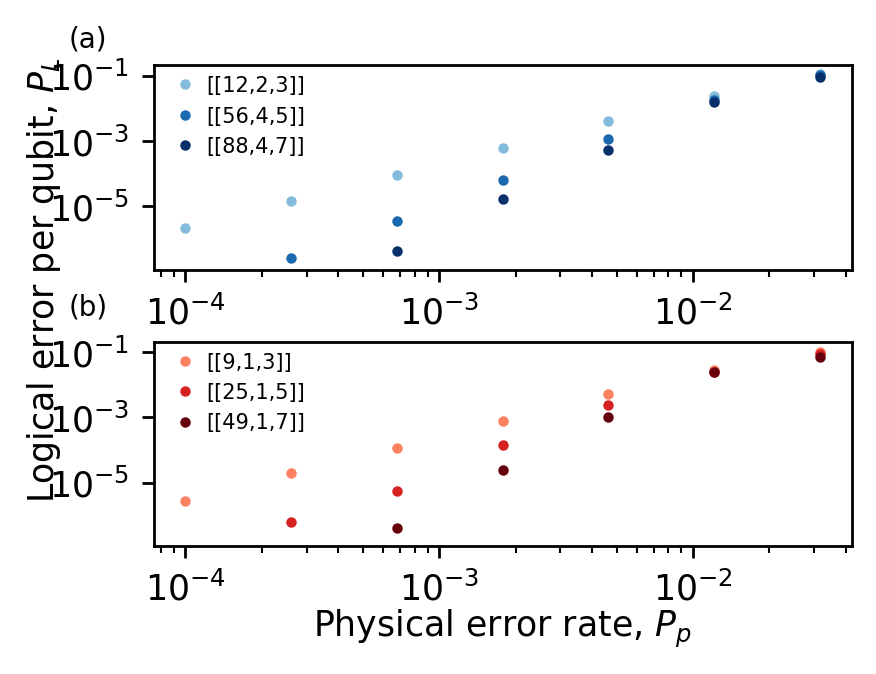

In [13]:
#1D plot of various qubit level detunings with resonator vs external flux
fig, ax = plt.subplots(ncols=1, nrows=2, dpi=250)

fig.subplots_adjust(bottom = 0.15, top=0.92, left=0.16, right=0.98, wspace=0.3, hspace=0.35)

# fig.set_size_inches(7.05826, 1.3)
fig.set_size_inches(3.40457, 2.5)
font = {'size' : 8}
mpl.rc('font', **font)

ax1 = ax[0]
ax2 = ax[1]

# p_th = 0.008
# A = 1.2
# ax1.plot(ps,A*p_th*(ps/p_th)**((3+1)/2))
# ax1.plot(ps,A*p_th*(ps/p_th)**((5+1)/2))
# ax1.plot(ps,A*p_th*(ps/p_th)**((9+1)/2))

for code in [code_2_3, code_4_5, code_4_7]:
    label = f"[[{code.n},{code.k},{code.d}]]"
    errors = errors_dict[label]
    ax1.plot(ps,1-(1-np.array(errors))**(1/code.k), '.', label=label, markersize=4, color=plt.cm.Blues((code.d + code.k//2)/9))
    # plt.plot(ps,1-(1-np.array(errors)), '.', label=label, markersize =7)



# plt.plot(ps,ps, '--', label=r'$P_L = P_p$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(r'Logical error per qubit, $P_L$')
ax1.yaxis.set_label_coords(-0.13, -0.05) 
# ax1.set_xlabel(r'Physical error rate, $P_p$')
ax1.legend(frameon=False, fontsize=6, loc=2, handletextpad=0.01, borderpad=0.01)


ax1.set_ylim(0.11e-6,0.21)

for d in [3,5,7]:
    label = f"[[{d**2},{1},{d}]]"
    errors = surface_dict[label]
    ax2.plot(ps,1-(1-np.array(errors)), '.', label=label, markersize=4, color=plt.cm.Reds(d/7))
    # plt.plot(ps,1-(1-np.array(errors)), '.', label=label, markersize =7)

# p_th = 0.011
# A = 3
# ax2.plot(ps,A*p_th*(ps/p_th)**((3+1)/2))
# ax2.plot(ps,A*p_th*(ps/p_th)**((5+1)/2))
# ax2.plot(ps,A*p_th*(ps/p_th)**((9+1)/2))
# plt.plot(ps,ps, '--', label=r'$P_L = P_p$')
ax2.set_yscale('log')
ax2.set_xscale('log')
# ax2.set_ylabel(r'Logical error rate per qubit, $P_L$')
ax2.set_xlabel(r'Physical error rate, $P_p$',labelpad=0)
ax2.legend(frameon=False, fontsize=6, loc=2, handletextpad=0.01, borderpad=0.0)
ax2.set_ylim(0.11e-6,0.21)

fig.text(0.06,0.95,'(a)',fontsize=8)
fig.text(0.06,0.52,'(b)',fontsize=8)

plt.savefig('performance_codes.pdf')

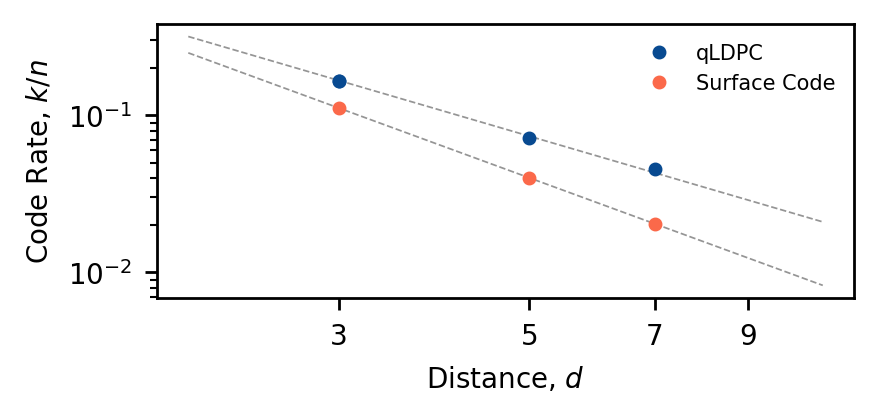

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=250)

fig.subplots_adjust(bottom = 0.25, top=0.98, left=0.16, right=0.98, wspace=0.3, hspace=0.4)

# fig.set_size_inches(7.05826, 1.3)
fig.set_size_inches(3.40457, 1.5)
font = {'size' : 8}
mpl.rc('font', **font)

dist = [code.d for code in codes]
rate = [code.k/code.n for code in codes]

# Model: rate = a / d^{x(d)}, with x(d) = x0 + x1/d
def variable_power_model(d, a, x0):
    x_d = x0 
    return a / d**x_d

# Fit model
params, _ = opt.curve_fit(variable_power_model, dist, rate, p0=[1.0, 1.0])

# Plotting
dist_fit = np.linspace(2, 11, 100)
rate_fit = variable_power_model(dist_fit, *params)

ax.plot(dist,rate,'.', label='qLDPC', color=plt.cm.Blues(0.9))
plt.plot(dist_fit, rate_fit, '--', color=plt.cm.Greys(0.5),zorder=0, linewidth=0.5)
ax.plot([3,5,7],[1/9,1/25,1/49],'.', label='Surface Code', color=plt.cm.Reds(0.5))
ax.plot([2,11],[1/2**2, 1/11**2],'--', color=plt.cm.Greys(0.5),zorder=0, linewidth=0.5)
ax.set_yscale('log')
ax.set_xscale('log' )
ax.tick_params(axis='x', which='minor', bottom=False, top=False)

ax.set_xticks([3, 5, 7, 9])
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set_xticklabels([3, 5, 7, 9])


ax.legend(frameon=False,fontsize=6)
ax.set_xlabel(r'Distance, $d$')
ax.set_ylabel(r'Code Rate, $k/n$')

plt.savefig('code_rate.pdf')

In [15]:
params

array([0.95988128, 1.59475591])